In [1]:
import pandas as pd
import numpy as np
import sys, os
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
   sys.path.append(project_root)

from source.utils.minio_helper import read_df_from_minio

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None) # Agar list panjang tidak terpotong

BUCKET_NAME = "mlbb-lakehouse"

In [17]:
df_enriched = read_df_from_minio(BUCKET_NAME, "silver/silver_draft_enriched.parquet", file_format='parquet')
df_pick = read_df_from_minio(BUCKET_NAME, "gold/gold_draft_pick_features.parquet", file_format='parquet')
df_match = read_df_from_minio(BUCKET_NAME, "gold/gold_match_features.parquet", file_format='parquet')

print("silver enriched shape:", df_enriched.shape)
print("gold_draft_pick_features shape:", df_pick.shape)
print("gold_match_features shape:", df_match.shape)

silver enriched shape: (8276, 21)
gold_draft_pick_features shape: (4139, 15)
gold_match_features shape: (827, 10)


In [ ]:
def create_gold_layer(df_silver):
    # A. Gold Pick Features
    df_picks = df_silver[df_silver['phase'] == 'pick'].copy()
    
    # Normalisasi Score
    max_score = df_picks['counter_score'].abs().max()
    if max_score == 0: max_score = 1
    df_picks['counter_score_norm'] = df_picks['counter_score'] / max_score
    
    # B. Gold Match Features (Aggregasi)
    agg_rules = {
        'is_winner_team': 'first',
        'team_name': 'first',
        'win_rate': 'mean',
        'tier_score': 'mean',
        'counter_score': 'mean',
        'counter_score_norm': 'mean',
        'hero_name_normalized': 'count'
    }
    
    df_matches = df_picks.groupby(['match_id', 'team_side']).agg(agg_rules).reset_index()
    df_matches = df_matches.rename(columns={
        'win_rate': 'avg_win_rate',
        'tier_score': 'avg_meta_score',
        'counter_score': 'avg_counter_score',
        'counter_score_norm': 'avg_counter_score_norm',
        'hero_name_normalized': 'total_hero'
    })
    
    return df_picks, df_matches

df_gold_picks, df_gold_matches = create_gold_layer(df_enriched)
print('Di fungsi create_gold_layer')
print(f"Gold Picks Shape: {df_gold_picks.shape}")
print(f"Gold Matches Shape: {df_gold_matches.shape}")

✅ Gold Picks Shape: (4139, 22)
✅ Gold Matches Shape: (828, 9)


In [14]:
# 1. Cek Missing Values (PENTING: Pastikan tidak ada NaN di fitur utama)
print("\n--- MISSING VALUES CHECK ---")
missing = df_gold_matches.isnull().sum()
print(missing[missing > 0])

# 2. Cek Statistik Deskriptif
# Perhatikan min/max pada avg_counter_score. Apakah range-nya masuk akal?
print("\n--- DESCRIPTIVE STATS ---")
display(df_gold_matches[['avg_win_rate', 'avg_meta_score', 'avg_counter_score', 'avg_counter_score_norm']].describe())
print(df_gold_matches[['avg_win_rate', 'avg_meta_score', 'avg_counter_score', 'avg_counter_score_norm']].describe())

# 3. Validasi Jumlah Hero
# Jika ada match yang heronya < 5, data itu sampah untuk ML.
invalid_drafts = df_gold_matches[df_gold_matches['total_hero'] != 5]
print(f"\n--- DATA INTEGRITY: INVALID DRAFTS ---")
print(f"Jumlah tim dengan hero != 5: {len(invalid_drafts)}")
if len(invalid_drafts) > 0:
   print(invalid_drafts.head())
   display(invalid_drafts.head())


--- MISSING VALUES CHECK ---
Series([], dtype: int64)

--- DESCRIPTIVE STATS ---


,avg_win_rate,avg_meta_score,avg_counter_score,avg_counter_score_norm
count,828.000000,828.000000,828.000000,828.000000
mean,49.849319,2.163285,0.156041,0.033775
std,1.151807,0.635130,0.168962,0.036572
min,46.358000,0.600000,0.000000,0.000000
25%,49.082000,1.800000,0.014000,0.003030
50%,49.872000,2.200000,0.106000,0.022944
75%,50.598500,2.600000,0.244500,0.052922
max,53.342000,4.400000,1.060000,0.229437


       avg_win_rate  avg_meta_score  avg_counter_score  avg_counter_score_norm
count    828.000000      828.000000         828.000000              828.000000
mean      49.849319        2.163285           0.156041                0.033775
std        1.151807        0.635130           0.168962                0.036572
min       46.358000        0.600000           0.000000                0.000000
25%       49.082000        1.800000           0.014000                0.003030
50%       49.872000        2.200000           0.106000                0.022944
75%       50.598500        2.600000           0.244500                0.052922
max       53.342000        4.400000           1.060000                0.229437

--- DATA INTEGRITY: INVALID DRAFTS ---
Jumlah tim dengan hero != 5: 1
     match_id team_side  is_winner_team   team_name  avg_win_rate  \
588       295      left            True  AuroraRORA       49.1925   

     avg_meta_score  avg_counter_score  avg_counter_score_norm  total_hero  
58

,match_id,team_side,is_winner_team,team_name,avg_win_rate,avg_meta_score,avg_counter_score,avg_counter_score_norm,total_hero
588,295,left,True,AuroraRORA,49.1925,4.0,0.32,0.069264,4


📊 ZERO SCORE DIAGNOSTIC
Total Pick Rows: 4139
Rows with Score 0: 2988
Percentage Zero: 72.19%
⚠️ WARNING: Lebih dari 50% data counter score bernilai 0. Cek kembali dictionary counter di Silver!


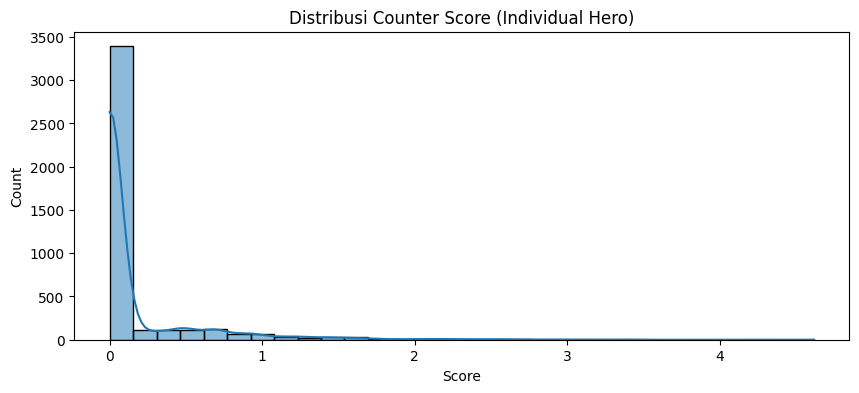

In [15]:
# Hitung persentase hero yang Counter Score-nya 0
zero_score_count = (df_gold_picks['counter_score'] == 0).sum()
total_picks = len(df_gold_picks)
pct_zero = (zero_score_count / total_picks) * 100

print(f"📊 ZERO SCORE DIAGNOSTIC")
print(f"Total Pick Rows: {total_picks}")
print(f"Rows with Score 0: {zero_score_count}")
print(f"Percentage Zero: {pct_zero:.2f}%")

# Interpretasi
if pct_zero > 50:
    print("⚠️ WARNING: Lebih dari 50% data counter score bernilai 0. Cek kembali dictionary counter di Silver!")
elif pct_zero > 20:
    print("⚠️ CAUTION: Cukup banyak score 0. Apakah data counter kurang lengkap?")
else:
    print("✅ PASS: Distribusi score terlihat normal (sedikit yang 0).")

# Visualisasi Histogram Score
plt.figure(figsize=(10, 4))
sns.histplot(df_gold_picks['counter_score'], bins=30, kde=True)
plt.title("Distribusi Counter Score (Individual Hero)")
plt.xlabel("Score")
plt.show()


--- FEATURE CORRELATION WITH WINNER ---
is_winner_team            1.000000
avg_meta_score            0.044904
avg_counter_score_norm    0.017752
avg_win_rate             -0.078336
Name: is_winner_team, dtype: float64


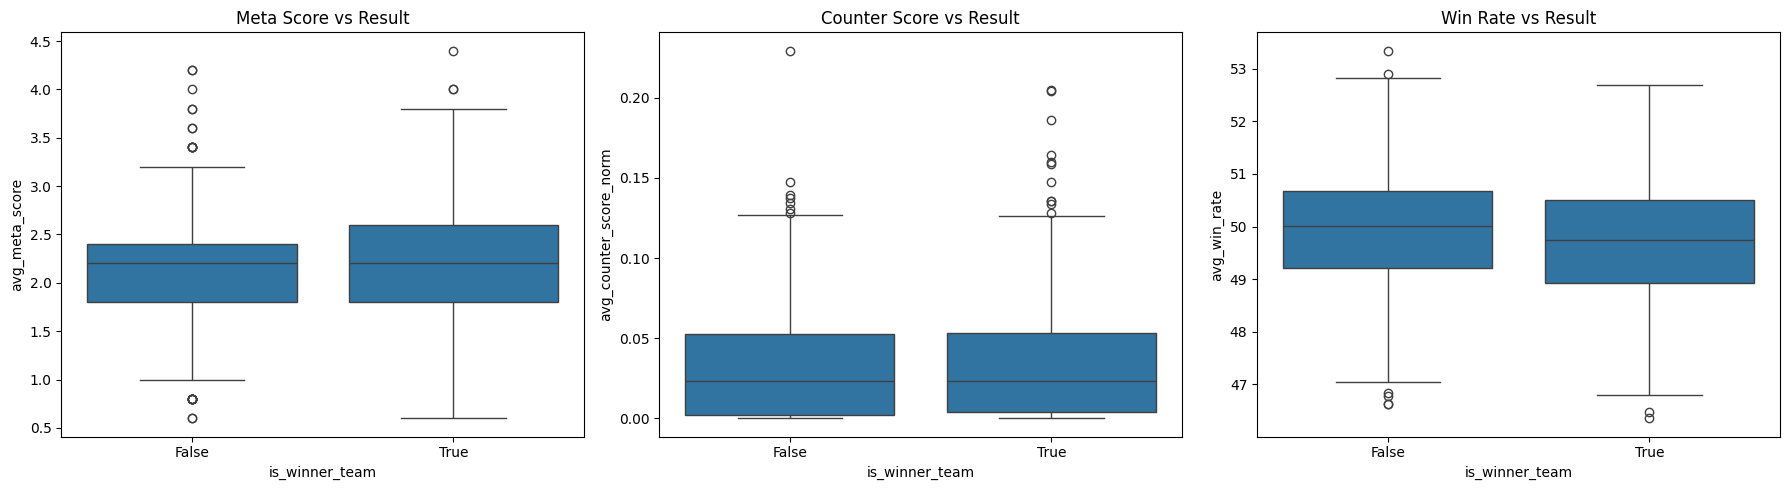

In [16]:
# Hitung Korelasi
features = ['is_winner_team', 'avg_win_rate', 'avg_meta_score', 'avg_counter_score_norm']
corr_matrix = df_gold_matches[features].corr()

print("\n--- FEATURE CORRELATION WITH WINNER ---")
print(corr_matrix['is_winner_team'].sort_values(ascending=False))

# Visualisasi Boxplot
# Kita ingin melihat apakah tim yang MENANG (1) cenderung punya score lebih tinggi
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(x='is_winner_team', y='avg_meta_score', data=df_gold_matches, ax=axes[0])
axes[0].set_title('Meta Score vs Result')

sns.boxplot(x='is_winner_team', y='avg_counter_score_norm', data=df_gold_matches, ax=axes[1])
axes[1].set_title('Counter Score vs Result')

sns.boxplot(x='is_winner_team', y='avg_win_rate', data=df_gold_matches, ax=axes[2])
axes[2].set_title('Win Rate vs Result')

plt.tight_layout()
plt.show()